In [19]:
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import re
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [80]:
# dataset location
DATASET = "data/prospect-data.csv"

# load dataset into dataframe
data = pd.read_csv(DATASET)

# clean up dataset
# might have to look at dropping seattle in the future but for clustering it 
# should not matter
#data = data[data['Team'] != 'SEA']

# try without goalies
#data = data[(data['Position'] != 'G')]
#data = data[(data['Position'] == 'C') | (data['Position'] == 'LW') | (data['Position'] == 'RW')]

# encode position
# TODO: we should keep the positions for when we do clustering
position = preprocessing.LabelEncoder()
position.fit(data['Position'].unique())
data['Position'] = data['Position'].apply(lambda x: position.transform([x])[0])

team = preprocessing.LabelEncoder()
team.fit(data['Team'].unique())
data['Team'] = data['Team'].apply(lambda x: team.transform([x])[0])


data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2022,3,76.0,218.0,1,15,1.0,Juraj Slafkovsky,Slafkovsky has all the assets you're looking f...,Slafkovsky is one of the draft's most tantaliz...,Slafkovsky can be a menace at the NHL level. H...,The potential of what Slafkovsky can be as he ...,Slafkovsky is one of the largest players in th...,Nothing brought out Juraj Slafkovsky's draft y...,Slafkovsky dominated the international scene t...,Juraj Slafkovsky drives offense from the wing....
1,2022,0,72.5,193.0,4,23,2.0,Shane Wright,Wright is a very well-rounded center who has n...,Still my top prospect in this class (though no...,The complicated and essential question to answ...,With high-end hockey sense highlighted by his ...,The top player from the class held this positi...,In a draft year shaped by substantial depth ra...,Wright has been on the radar of scouts for a l...,Shane Wright is an elite two-way center with i...
2,2022,1,72.0,190.0,2,16,4.0,Simon Nemec,Nemec is a very well-rounded defenseman. His p...,This kid turned 18 in the middle of February a...,"With Nemec, you are netting a top pairing defe...","One of the very best passers in this draft, Ne...",The statistical comparables to Nemec's draft y...,Šimon Nemec just put together the most product...,Few players have been as dominant at the pro-l...,Simon Nemec is a mobile two-way and highly-int...
3,2022,0,70.5,180.0,3,1,3.0,Logan Cooley,Cooley is a dynamic player. When he has the pu...,"Cooley is a beautiful, flowing skater capable ...",Logan Cooley is for sure one of the more well-...,"Over the last several months, I have constantl...","A highly creative, speed-driven pivot who brin...",You won't find a more singularly-gifted puckha...,"A small, speedy center, Cooley dominated the U...",Juraj Slafkovsky drives offense from the wing....
4,2022,1,75.0,189.0,6,5,5.0,David Jiricek,"Jiricek is a big, right-shot defenseman who ma...",After suffering a knee injury at the world jun...,Top pairing defenseman at the NHL level if he ...,"A highly mobile, 6-foot-3 defenseman with a bo...","A knee injury fractured Jiříček's season, but ...",David Jiříček finishes the year as the highest...,"Similar to Nemec, Jiricek plays a mature game ...",David Jiricek is an exceptional two-way defens...


In [81]:
corpus, labels, draft_position, player_position, player_name, team, height, weight = [], [], [], [], [], [], [], []

scouting_reports = [
    'Description - Corey Pronman',
    'Description - Scott Wheeler',
    'Description - Smaht Scouting',
    'Description - ESPN (Chris Peters)',
    'Description - EP Rinkside', 
    'Description - EP Rinkside Part 2',
    'Description - The Painted Lines',
    'Description - FCHockey'
]


# remove references to leagues, teams, and nationalities
hockey_words = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "chl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "liiga", 
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "saginaw", "kelowna", "frolunda",
                "slovakia"]


for index, row in data.iterrows():
  text = ""
  for report in scouting_reports:
    # skip null reports
    if pd.isnull(row[report]):
      continue

    scouting_report = row[report]
    scouting_report = scouting_report.lower()
    # remove player name from report
    names = row['Name'].lower().split(' ')
    for name in names:
      scouting_report = scouting_report.replace(name + "'s", '')
      scouting_report = scouting_report.replace(name, '')
    
    scouting_report = scouting_report.replace('\n', ' ')
    scouting_report = scouting_report.replace('\r', '')

    # remove hockey specific stop words
    # TODO: there is an issue where a hockey word includes punctuation, it does not get removed
    # for instance: "usntdp," will not get removed
    scouting_report = scouting_report.split()
    scouting_report = [word for word in scouting_report if (word.replace("'s", "").replace(",", "").replace(".", "") not in hockey_words)]
    # join back on spaces
    scouting_report = ' '.join(scouting_report)

    text = text + " " + scouting_report

  # append to dataset
  corpus.append(text)
  labels.append(row['Team'])
  draft_position.append(row['Drafted'])
  player_position.append(row['Position'])
  player_name.append(row['Name'])
  team.append(row['Team'])
  height.append(row['Height'])
  weight.append(row['Weight'])
# sanity check values
print(f"length of corpus: {len(corpus)}")
print(f"length of labels: {len(labels)}")
print(f"length of draft_position: {len(draft_position)}")
print(f"length of player_position: {len(player_position)}")

print(f"corpus first 5: {corpus[0:5]}")
print(f"labels first 5: {labels[0:5]}")
print(f"draft_position first 5: {draft_position[0:5]}")
print(f"player_position first 5: {player_position[0:5]}")

length of corpus: 360
length of labels: 360
length of draft_position: 360
length of player_position: 360
corpus first 5: [" has all the assets you're looking for in a top nhl forward. he's a 6-foot-4 winger who can beat opponents with speed and skill. he possesses outstanding puck skills and can put pucks through legs and sticks at a very high rate. can use finesse, or power and quickness to get around defenders. can also set up and finish plays well. physically, he won't run over guys but his compete is good enough. he projects as a top-line winger with the potential to pop and become a true star in the nhl. is one of the draft's most tantalizing prospects, with a skill-size combo that scouts and coaches clamour for and he has already demonstrated against pro competition domestically and, more notably, internationally. it has been a big year for him. nine points in five games and a historic silver medal for the slovaks at the hlinka gretzky cup. an olympic bronze medal as the tourname

In [82]:
# attempting to vectorize using bert embeddings
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-mpnet-base-v2')
model.max_seq_length = 510
X = pd.DataFrame(list(zip(team, player_name, draft_position, height, weight, player_position, corpus)), columns=['team', 'player_name', 'draft_position', 'height', 'weight', 'player_position', 'report'])
X['embeddings'] = 0
X['embeddings'] = X['embeddings'].astype('float64')
Y = labels

# create train test splits of data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

#print(f"Boqvist Report: {X_train[X_train['player_name'] == 'Jesper Boqvist']['report'].values[0]}")
sentences = X_train['report'].values
players = X_train['player_name'].values
#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:10]:
    print("{} \t {} \t {:.4f}".format(players[i], players[j], cos_sim[i][j]))

Top-5 most similar pairs:
Andreas Englund 	 Dominik Masin 	 0.9529
Noah Ostlund 	 Frank Nazar 	 0.9528
Marcus Pettersson 	 Henri Jokiharju 	 0.9522
Noah Ostlund 	 Roni Hirvonen 	 0.9517
Matthew Savoie 	 Cutter Gauthier 	 0.9515
Philip Tomasino 	 Henri Jokiharju 	 0.9509
Brandon Carlo 	 Andreas Englund 	 0.9496
Frank Nazar 	 Logan Cooley 	 0.9483
Tobias Bjornfoot 	 Grigori Denisenko 	 0.9478
Seamus Casey 	 Henri Jokiharju 	 0.9471


In [125]:
VECTOR_SIZE = 100
from sklearn.preprocessing import Normalizer

print(f"pre-normalized embeddings: {embeddings[0].mean(axis=0)}")
transformer = Normalizer().fit(embeddings)
embeddings = transformer.transform(embeddings)
print(f"post-normalized embeddings: {embeddings[0].mean(axis=0)}")
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv.index_to_key]
    if len(words_vecs) == 0:
        return np.zeros(VECTOR_SIZE)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

converted_embeddings = [embedding.mean(axis=0, dtype=np.float64) for embedding in embeddings]
X_train['embeddings'] = [embedding for embedding in embeddings]
#X_train['embeddings'] = [embedding.mean(axis=0, dtype=np.float64) for embedding in embeddings]
#X_test['report'] = np.array([vectorize(sentence) for sentence in X_test['report'].values])

X_train['embeddings'].head(1)

pre-normalized embeddings: -0.00012965565838385373
post-normalized embeddings: -0.00012965565838385373


70    [-0.014798667, 0.050005537, 0.016570205, 0.004...
Name: embeddings, dtype: object

Exploring Kmeans now for unsupervised learning

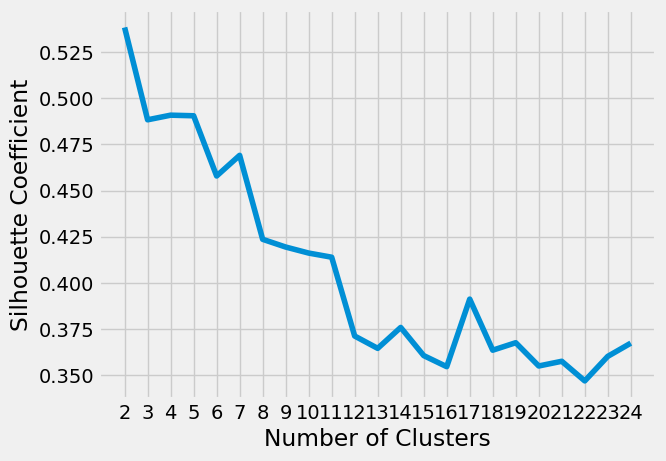

In [126]:
def plot_silhouette_scores(data, start, end, step):
  # A list holds the silhouette coefficients for each k
  silhouette_coefficients = []
  formated_data = data

  # Notice you start at 2 clusters for silhouette coefficient
  for k in range(start, end, step):
    kmeans = KMeans(n_clusters=k, n_init=2, max_iter=1000)
    kmeans.fit(formated_data)
    score = silhouette_score(formated_data, kmeans.labels_)
    silhouette_coefficients.append(score)

  plt.style.use("fivethirtyeight")
  plt.plot(range(start, end, step), silhouette_coefficients)
  plt.xticks(range(start, end, step))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()



formated_data = np.vstack(X_train['embeddings'])
temp_data = []
for index, row in enumerate(formated_data):
  temp_data.append(np.concatenate((formated_data[index], [X_train['height'].values[index]], [X_train['weight'].values[index]])))
  #formated_data[index] = np.append(formated_data[index], X_train['weight'].values[index])
data = np.array(temp_data)
plot_silhouette_scores(data, 2, 25, 1)

The extremely low silhouette score implies there is a lot of overlap in classification of values. There might have to be some more data massaging in order to get this value higher

In [129]:
SELECTED_CLUSTERS = 4

In [130]:
# use the number of clusters found to be the best in graph above
kmeans = KMeans(n_clusters=SELECTED_CLUSTERS, n_init = 5)
#labels = kmeans.fit_predict(np.array(X_train[['embeddings', 'height', 'weight']]).reshape(-1, 1))
labels = kmeans.fit_predict(data)

X_train['label'] = labels

In [131]:
# show the top words for each cluster that was created
def get_top_features_cluster(X_train):
    data = X_train[X_train['label'] == 14]
    for index, row in data.iterrows():
        print("")
        print("player name: {}", row['player_name'])
        print(row['report'])
        
    

get_top_features_cluster(X_train)

In [132]:
import plotly.express as px

print(X_train.columns)
print(X_train.head())

#visualize mappings via treemap
result_summary = pd.pivot_table(X_train, index=['label', 'player_name'],  aggfunc='count').reset_index().rename(columns={'draft_position':'count'})
result_treemap = result_summary
fig = px.treemap(result_treemap,path=['label', 'player_name'],values='count')
fig.show()

Index(['team', 'player_name', 'draft_position', 'height', 'weight',
       'player_position', 'report', 'embeddings', 'label'],
      dtype='object')
     team      player_name  draft_position  height  weight  player_position  \
70      0   Sasha Pastujov              66   72.00   175.0                4   
76      4     Scott Morrow              40   74.00   198.0                1   
19      3     Noah Ostlund              16   70.00   164.0                0   
155     4  Pyotr Kochetkov              36   75.25   180.0                2   
309     1     Nick Merkley              30   70.50   191.0                4   

                                                report  \
70    has been a very productive player with the u....   
76    played most of the year at shattuck's u18 tea...   
19    possesses impressive speed and skill. he's ab...   
155   a third-year eligible goaltender, really turn...   
309   had a very impressive season as one of the to...   

                          

c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



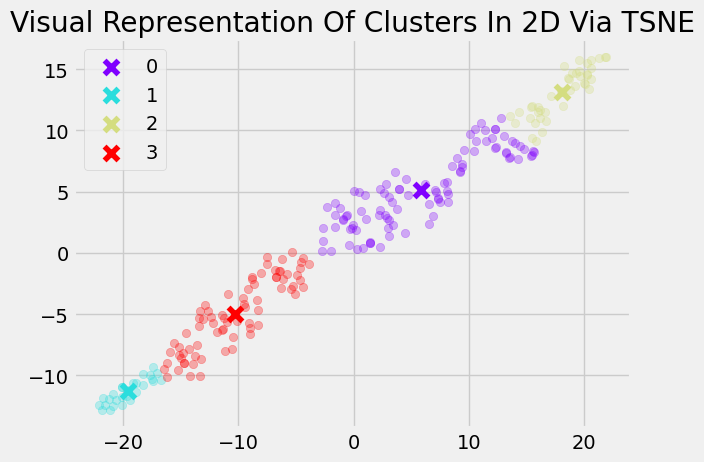

In [133]:
tsne = TSNE(n_components=2, learning_rate=200)
#data = X_train['embeddings'].values
vis_dims2 = tsne.fit_transform(data)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

color = cm.rainbow(np.linspace(0, 1, len(X_train.label.unique())))
for category, color in enumerate(color):
    xs = np.array(x)[X_train.label == category]
    ys = np.array(y)[X_train.label == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=category)
plt.title("Visual Representation Of Clusters In 2D Via TSNE")
plt.legend()

In [120]:

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_train[['player_position', 'draft_position', 'label']], X_train['team'], test_size=0.33)
lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)

print(f"Linear Regression Score: {lr.score(X_test_lr, y_test_lr)}")



Linear Regression Score: -0.006529811522072659
